In [1]:
%env THEANO_FLAGS=device=gpu0,lib.cnmem=0.9,floatX=float32
%env USER_EMB_SIZE=256
import sys
sys.path.insert(0, '../')

from __future__ import unicode_literals

from mymodule.neural.discriminator import DssmModel
from mymodule.base_stuff import Vocab
from agentnet.utils.persistence import load, save
from mymodule.twitter_stuff import iterate_minibatches_twitter_dssm
import codecs
from collections import defaultdict
from tqdm import tqdm

env: THEANO_FLAGS=device=gpu0,lib.cnmem=0.9,floatX=float32
env: USER_EMB_SIZE=256


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5110)


In [2]:
vocab_path = '../twitter_data/tokens.txt'
dssm_data_train = '../twitter_data/dssm_data_train'
dssm_data_val = '../twitter_data/dssm_data_val'
pretrained_encoder_path = '../weights/test_twitter_encoder.pkl'
num_users = 1000

In [3]:
vocab = Vocab.read_from_file(vocab_path)

In [4]:
dssm_model = DssmModel(vocab, num_users)
load(dssm_model.l_utt_enc.output, pretrained_encoder_path)

In [45]:
load(dssm_model.l_user_semantic, '../weights/dssm_model_l_user_semantic.pkl')
load(dssm_model.l_utt_semantic, '../weights/dssm_model_l_utt_semantic.pkl')

In [ ]:
u2lines = defaultdict(list)
with codecs.open("../twitter_data/dssm_data_val", encoding='utf8') as fin:
    for line in tqdm(fin):
        uid, msg = line.strip().split('\t')
        u2lines[uid].append(msg)

10000it [00:00, 123730.53it/s]


In [46]:
u2lines = dict([(key, u2lines[key]) for key in u2lines.keys()[:100]])

In [47]:
uid2uid2scores = defaultdict(lambda: defaultdict(list))

for uid1 in tqdm(u2lines):
    for uid2 in u2lines:
        for line in u2lines[uid2]:
            uid2uid2scores[uid1][uid2].append(dssm_model.similarity(uid1, line))


  2%|▏         | 2/100 [00:04<03:41,  2.26s/it]

100%|██████████| 100/100 [03:46<00:00,  2.37s/it]


In [48]:
u2lines.keys()[:10]

[0, u'344', u'0', u'346', u'347', u'340', u'341', u'342', u'343', u'810']

In [38]:
from mymodule.base_stuff import phrase2matrix

In [53]:
dssm_model.predict_d_op(np.array([344]), phrase2matrix([u2lines['810'][10]], dssm_model.vocab, normalize=False))[0]

0.0

In [40]:
dssm_model.similarity(198, u2lines['198'][0])

0.026546506

In [32]:
u2lines['198']

[u'\u0445\u043e\u0440\u043e\u0448\u043e )',
 u'\u043e\u043d \u043a\u0440\u0443\u0442\u043e\u0439 \u0432\u043e\u043e\u0431\u0449\u0435, \u0442\u043e\u043b\u044c\u043a\u043e \u0432\u043e\u0442 \u044d\u0442\u0430 \u043f\u0440\u043e\u0431\u043b\u0435\u043c\u0430 \u0441 \u0431\u0430\u0442\u0430\u0440\u0435\u0439\u043a\u043e\u0439...',
 u'\u043d\u0443 \u0447\u0442\u043e \u0437\u0430 \u0432\u043e\u043f\u0440\u043e\u0441\u044b (',
 u'\u043f\u043e\u0437\u0434\u043d\u043e )',
 u'\u043e\u0445',
 u'\u043d\u0435\u0442 :-(',
 u'\u0431\u044b\u0432\u0430\u0435\u0442 \u0438 \u043d\u0435\u043f\u043b\u043e\u0445\u043e\u0435',
 u'\u043d\u0430\u0434\u043e \u0431\u0440\u0430\u0442\u044c!',
 u'\u043d\u0435 \u0437\u043d\u0430\u044e, \u0432\u0441\u044f \u043b\u0435\u043d\u0442\u0430 \u0432 \u044d\u0442\u043e\u043c. \u041d\u0430\u0432\u0435\u0440\u043d\u043e\u0435 \u043f\u043e\u043f\u0443\u043b\u044f\u0440\u043d\u0430\u044f \u0442\u0435\u043c\u0430',
 u'\u0434\u0430 \u044f \u0448\u0443\u0447\u0443, \u043d\u0430

In [70]:
uid2uid2scores = filter(lambda x: len(x[1])>0, uid2uid2scores.iteritems())
uid2uid2scores = dict(uid2uid2scores)

In [58]:
import numpy as np

In [59]:
corrs = np.zeros((len(uid2uid2scores), len(uid2uid2scores)))

In [72]:
all_uids = uid2uid2scores.keys()

In [73]:
for i in xrange(len(all_uids)):
    for j in xrange(len(all_uids)):
        uid1 = all_uids[i]
        uid2 = all_uids[j]
        
        corrs[i][j] = np.mean(uid2uid2scores[uid1][uid2])

/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
uid2uid2scores[0]

defaultdict(list,
            {0: [],
             150: [],
             u'0': [0.53604031,
              0.031763356,
              0.84206265,
              0.55222499,
              0.89695668,
              0.26350716,
              0.76715487,
              0.76260775,
              0.52618754,
              0.51064509,
              0.73470563,
              0.73806721,
              0.75307399,
              0.71486121,
              0.40322959,
              0.054059938,
              0.84313416,
              0.74944413,
              0.083097167,
              0.85326248,
              0.47107986,
              0.099542372,
              0.80216146,
              0.51252168,
              0.52229923,
              0.60757679,
              0.80677748,
              0.68252444,
              0.81658036,
              0.73559654,
              0.62256128,
              0.1910869,
              0.00010437705,
              0.469345,
              0.56198108,
              0.8109

In [75]:
np.diagonal(corrs)

array([        nan,  0.99419826,  0.59244424,  0.32238472,  0.99321461,
        0.9924649 ,  0.99177104,  0.99302548,  0.99410284,  0.52439463,
        0.55993617,  0.72011238,  0.68039596,  0.98822892,  0.72786605,
        0.40161151,  0.67536432,  0.41883868,  0.68230373,  0.71801043,
        0.69229674,  0.62629604,  0.60269982,  0.45202622,  0.43428907,
        0.61916393,  0.73624611,  0.92410082,  0.60064715,  0.99193722,
        0.61420822,  0.98644078,  0.7210809 ,  0.57751465,  0.64015538,
        0.45171142,  0.68548948,  0.75321633,  0.58132929,  0.82408714,
        0.7351324 ,  0.72584504,  0.76940304,  0.82312167,  0.66690737,
        0.66388392,  0.67959118,  0.58237571,  0.70175332,  0.70881075,
        0.60530901,  0.51776016,  0.4306491 ,  0.63449323,  0.66156882,
        0.7006495 ,  0.70234466,  0.54500812,  0.41380605,  0.82894772,
        0.51466459,         nan,  0.6415208 ,  0.64608806,  0.64994597,
        0.61112386,  0.67446977,  0.65669978,  0.66593081,  0.88

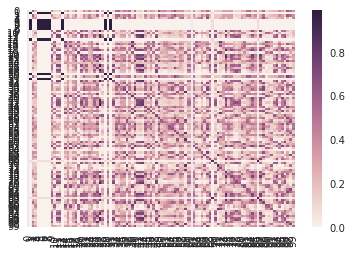

In [78]:
sns.heatmap(corrs)